In [632]:
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [633]:
sys.path.append("../src")

In [634]:
from model.train import train_model
from model.model_utils import export_model
from feature_selector import select_features
from data_loader import load_dataset, export_dataset
from plotting.plot_utils import plot_r2_depth_profile, plot_feature_importance, plot_bbp_profiles, plot_relative_error, plot_validation_scatter
from model.model_metrics import overall_metrics, save_overall_metrics, depth_metrics, overall_validation_metrics, \
save_overall_validation_metrics,depth_val_metrics
from utils import start_experiments, ExportConfig, ExperimentSetup, prepare_xy, log10_to_bbp

# Single Experiment Walktrough

This notebook runs a single experiment configuration at one specific region, depth, and feature set. 
It includes:

- Data loading and preprocessing
- Model training
- Validation and metric computation
- Scatter and profile plots
- Optional export of results
  
To run all experiments automatically across configurations, use the batch script:

`src/TO DO`

### Configure experiment settings

In [635]:
print(f"Regions:{ExperimentSetup.ALL_REGIONS}") 
print(f"Depths:{ExperimentSetup.ALL_DEPTHS}") 
print(f"Experiments:{ExperimentSetup.ALL_EXPERIMENTS}") 

Regions:['NA', 'STG']
Depths:['50', '250']
Experiments:['GCGOBGC', 'S3OLCIBGC', 'S3IOPS', 'S3OLCI']


In [636]:
setup = ExperimentSetup(region="NA", depth="250", experiment="GCGOBGC")

In [637]:
print(f"{setup}")
print(f"Validation float = {setup.validation_float()}")

ExperimentSetup(region='NA', depth='250', experiment='GCGOBGC')
Validation float = 6902671


Configure exports

In [638]:
exports = ExportConfig(export_datasets=True, 
                         export_model=True, 
                         export_model_metrics=True, 
                         export_fig_depth=True, 
                         export_fig_profile=True, 
                         export_fig_importance=True, 
                         export_validation_metrics=True, 
                         export_fig_val=True)

In [639]:
start_experiments()

Folders are configured.


In [640]:
train, validation = load_dataset(setup)

In [641]:
print(f"Training set = {train.shape[0]} samples")
print(f"Input features = {train.shape[1]}")
print(f"Validation set = {validation.shape[0]}")

Training set = 376 samples
Input features = 218
Validation set = 35


In [642]:
export_dataset(train, validation, setup) if exports.export_datasets else None

Data exported to: ../datasets/training/Train_NA_250_GCGOBGC.txt and ../datasets/validation/Validation_NA_250_GCGOBGC.txt


In [643]:
dataset_features, bbp_outputs = select_features(train, setup)

In [644]:
# Prepare train/test
X, y_log = prepare_xy(train, dataset_features, bbp_outputs)

In [645]:
x_train, x_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [646]:
model = train_model(x_train, y_train_log)

In [647]:
y_pred_log = model.predict(x_test)

In [648]:
y_pred_bbp = log10_to_bbp(y_pred_log)
y_test_bbp = log10_to_bbp(y_test_log)

In [649]:
export_model(model, setup) if exports.export_model else None

Model saved to: ../results/NA/250/GCGOBGC/Model/NA_250_GCGOBGC_model.sav


In [650]:
ov_metrics = overall_metrics(y_test_bbp,y_pred_bbp)

In [651]:
print(f"Overall metrics for {setup.region, setup.depth, setup.experiment}:")
ov_metrics

Overall metrics for ('NA', '250', 'GCGOBGC'):


{'R2': 0.7765058107762293,
 'MSE': 7.086136496335442e-08,
 'MAE': 8.508718915518776e-05,
 'RMSE': 0.00018162874587945987,
 'MAPD': np.float64(3.3702087481542002)}

In [652]:
save_overall_metrics(ov_metrics,setup)if exports.export_model_metrics else None

Saved overall metrics to ../results/NA/250/GCGOBGC/Model/Metrics


In [653]:
depth_metrics_df = depth_metrics(y_test_bbp,y_pred_bbp, setup)

In [654]:
depth_metrics_df.to_csv(f"../results/{setup.region}/{setup.depth}/{setup.experiment}/Model/Metrics/\
{setup.region}_{setup.depth}_{setup.experiment}_depth_metrics.csv")if exports.export_model_metrics else None

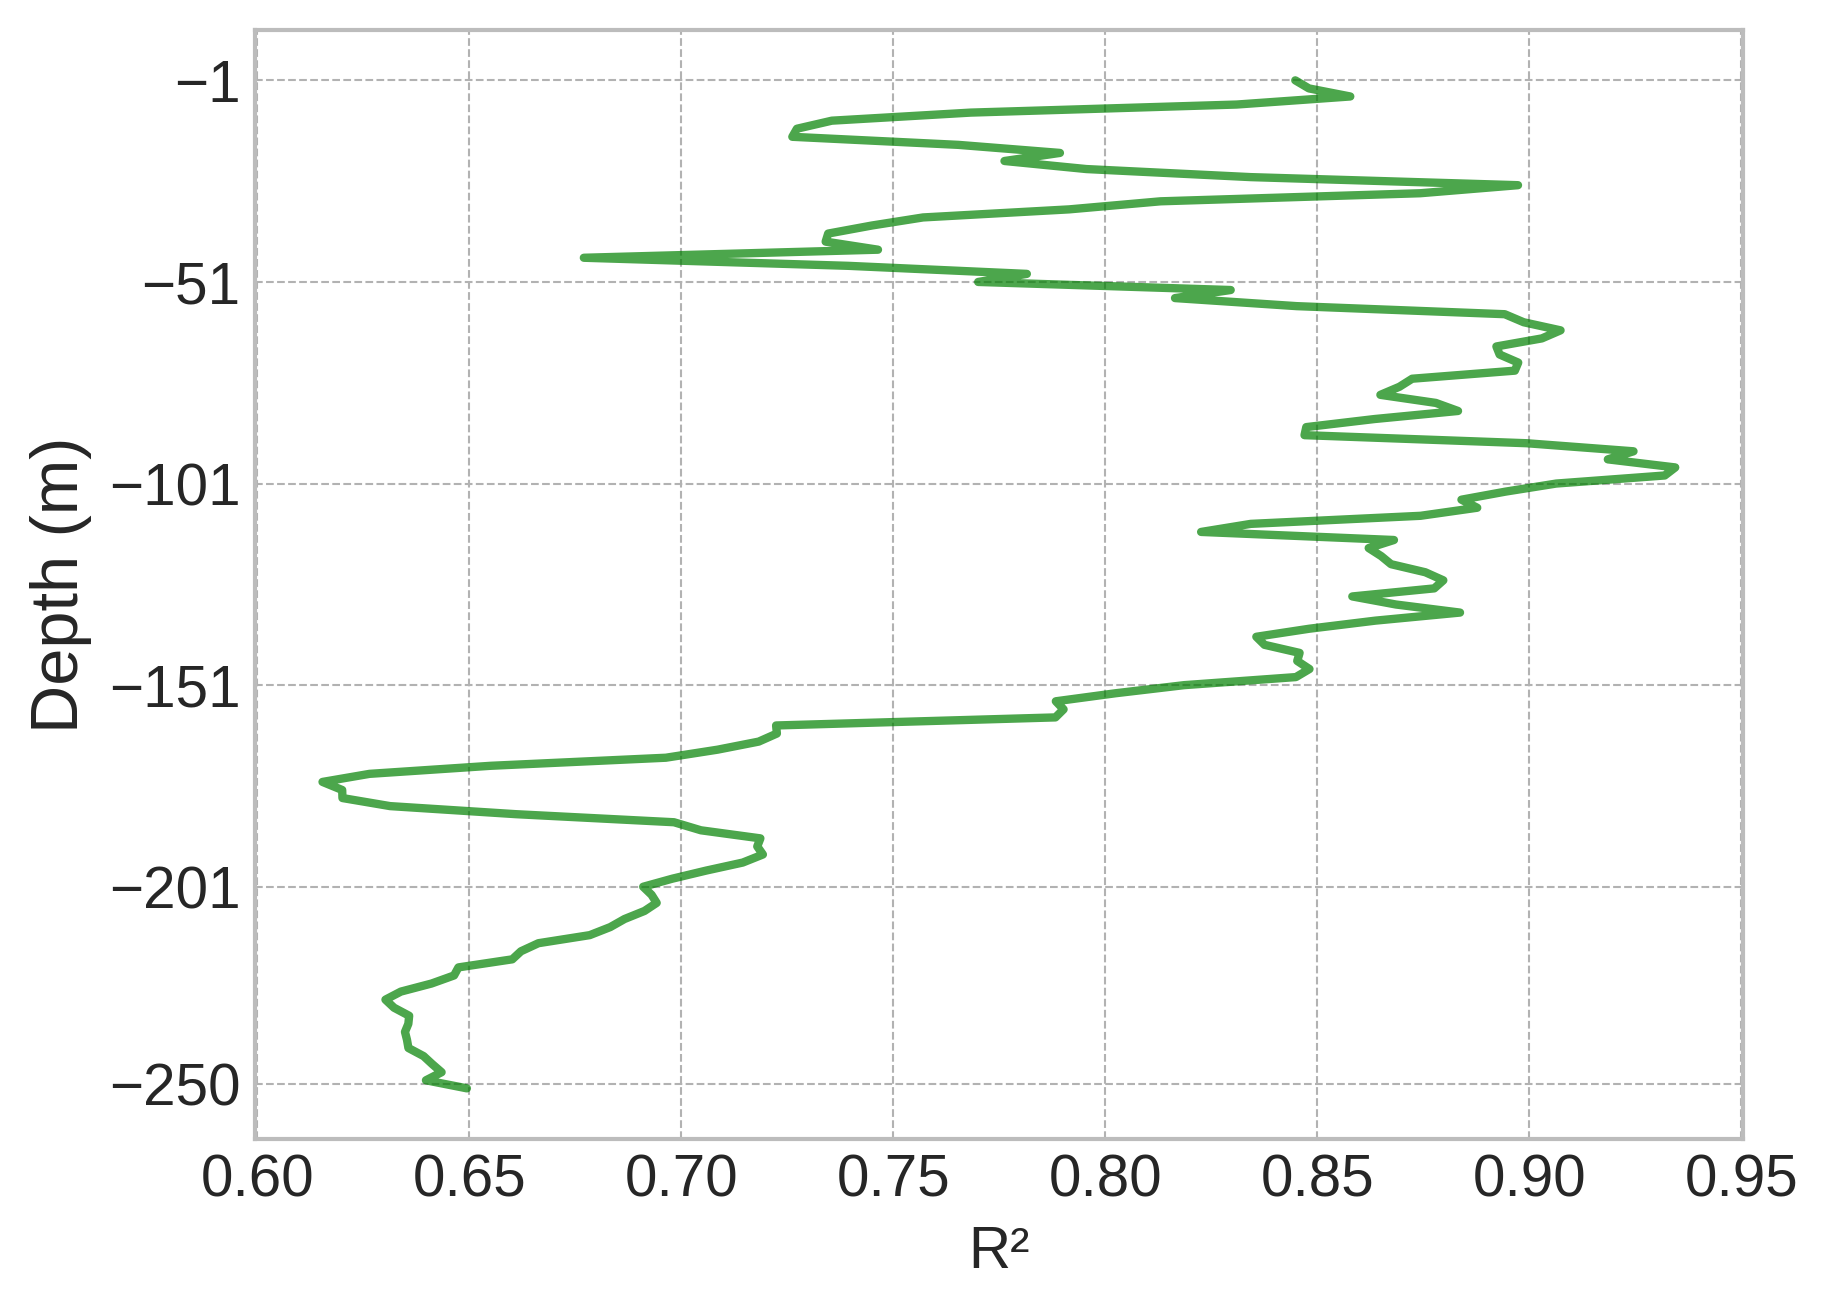

In [655]:
plot_r2_depth_profile(depth_metrics_df, setup,exports)

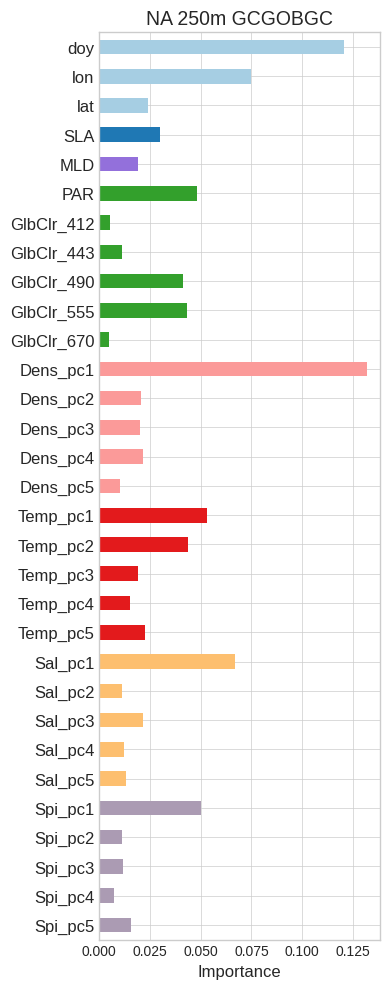

In [656]:
plot_feature_importance(model,x_train, setup, exports)

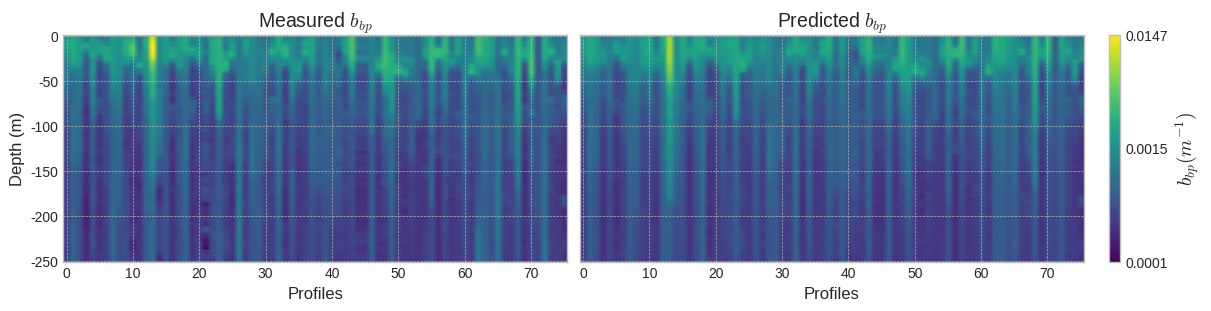

In [657]:
plot_bbp_profiles(y_test_bbp, y_pred_bbp, setup, exports)

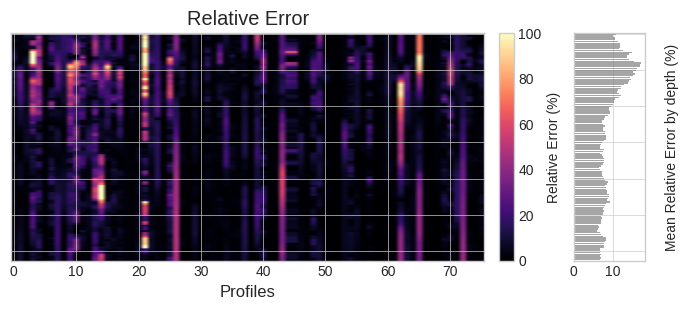

In [658]:
plot_relative_error(y_test_bbp, y_pred_bbp, setup, exports)

In [659]:
# Prepare validation
x_val, y_val_log= prepare_xy(validation, dataset_features, bbp_outputs)

In [660]:
y_pred_val_log = model.predict(x_val)

In [661]:
y_pred_val_bbp = log10_to_bbp(y_pred_val_log)
y_val_bbp = log10_to_bbp(y_val_log)

In [662]:
ov_metrics_val = overall_validation_metrics(y_val_bbp,y_pred_val_bbp)

In [663]:
ov_metrics_val

{'R2': 0.3194348604869012,
 'MSE': 3.24074549275918e-08,
 'MAE': 7.496110627222892e-05,
 'RMSE': 0.00010400053672637215,
 'MAPD': np.float64(6.563573437658086)}

In [664]:
save_overall_validation_metrics(y_val_bbp, y_pred_val_bbp,setup, exports)

Saved overall validation metrics to: ../Results/NA/250/GCGOBGC/Validation/Metrics/NA_250_GCGOBGC_Val_overall_metrics.csv


In [665]:
depth_val_metrics_df = depth_val_metrics(y_val_bbp, y_pred_val_bbp, setup)

<Figure size 800x800 with 0 Axes>

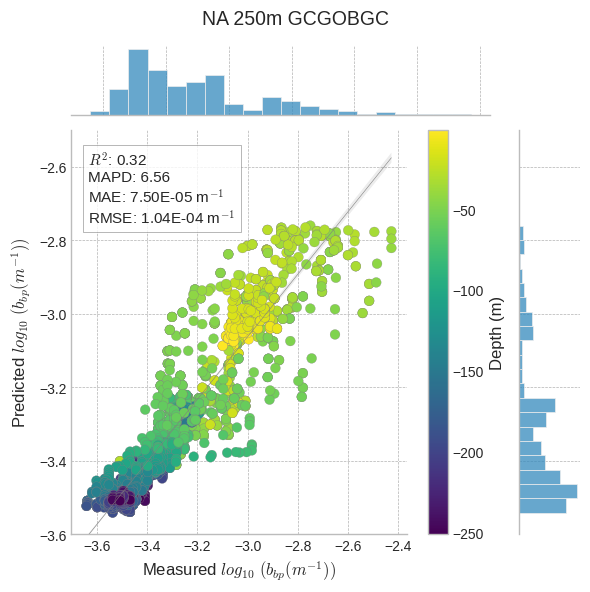

In [666]:
plot_validation_scatter(depth_val_metrics_df, y_val_log, y_pred_val_log, setup, exports)